In [1]:
#pip install numpy pandas matplotlib seaborn pydantic scipy openpyxl bokeh holoviews hvplot neuprint-python
import os
import time
import math
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fafbseg import flywire
import flycode.utils as utils
import flycode.readfiles as readfiles
import flycode.mapping as mapping
import flycode.neuprint_reading as neuread
import flycode.reduction as reduction
import flycode.specific as specific
import flycode.maintenance as maintenance
import flycode.meshes as meshes
import flycode.proofreading as proofreading
import flycode.synapse_density as density
import flycode.metu_comparison as comparison
import flycode.annotations as annotations
import flycode.volumes as volumes
import flycode.flywire_functions as fw
import flycode.figures as figures
import flycode.path_weights as path_weights
line_width = 0.2#0.0645
plt.rcParams["font.family"] = ["Arial", "sans-serif"]
plt.rcParams["axes.linewidth"] = line_width
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["xtick.major.width"] = line_width
plt.rcParams["xtick.minor.width"] = line_width
plt.rcParams["ytick.major.width"] = line_width
plt.rcParams["ytick.minor.width"] = line_width


#Easy reference type lists.
all_mt_types = ["1","2a","2b","3a","3b","3c","4a","4b","4c","4d"]
mt1_l = ["MeTu1_L"]
mt1_r = ["MeTu1_R"]
mt2_l = [f"MeTu2{x}_L" for x in "ab"]
mt2_r = [f"MeTu2{x}_R" for x in "ab"]
mt3_l = [f"MeTu3{x}_L" for x in "abc"]
mt3_r = [f"MeTu3{x}_R" for x in "abc"]
mt4_l = [f"MeTu4{x}_L" for x in "abcd"]
mt4_r = [f"MeTu4{x}_R" for x in "abcd"]
mt_l = mt1_l + mt2_l + mt3_l + mt4_l
mt_r = mt1_r + mt2_r + mt3_r + mt4_r
all_mt_l = mt_l
all_mt_r = mt_r + ["MeTu_incomplete_R"]
all_mt = mt_l + mt_r
mt_l_general = [f"MeTu{x}_L" for x in "1234"]
mt_r_general = [f"MeTu{x}_R" for x in "1234"]
tb_pl_l = ["TuBu08_L"]
tb_pl_r = ["TuBu08_R"]
pc_tb_types = "16"
tb_pc_l = [f"TuBu0{x}_L" for x in pc_tb_types]
tb_pc_r = [f"TuBu0{x}_R" for x in pc_tb_types]
a_tb_types = ["07","09","10"]
tb_a_l = [f"TuBu{x}_L" for x in a_tb_types]
tb_a_r = [f"TuBu{x}_R" for x in a_tb_types]
m_tb_types = "2345"
tb_m_l = [f"TuBu0{x}_L" for x in m_tb_types]
tb_m_r = [f"TuBu0{x}_R" for x in m_tb_types]
all_tb_types = [f"0{x!s}" if x<10 else str(x) for x in range(1,11)]
tb_l = [f"TuBu{x}_L" for x in all_tb_types]
tb_r = [f"TuBu{x}_R" for x in all_tb_types]
er_pl_l = ["ER4d_L"]
er_pl_r = ["ER4d_R"]
pc_ring_types = ["4m","5"]
er_pc_l = [f"ER{x}_L" for x in pc_ring_types]
er_pc_r = [f"ER{x}_R" for x in pc_ring_types]
a_ring_types = ["3w_ab","2_ad","2_b","2_c"]
er_a_l = [f"ER{x}_L" for x in a_ring_types] 
er_a_r = [f"ER{x}_R" for x in a_ring_types]
er_a = [f"ER{x}_{y}" for x in a_ring_types for y in "LR"]
m_ring_types = ["3a_ad","3m","3d_a","3d_b","3d_c","3d_d","3p_ab"]
er_m_l = [f"ER{x}_L" for x in m_ring_types]
er_m_r = [f"ER{x}_R" for x in m_ring_types]
all_ring_types = ["2_ad","2_b","2_c",
                  "3a_ad","3d_a","3d_b","3d_c","3d_d","3m","3p_ab","3w_ab",
                  "4d","4m",
                  "5"]
er_l = [f"ER{x}_L" for x in all_ring_types]
er_r = [f"ER{x}_R" for x in all_ring_types]
er_all = [f"ER{x}_{y}" for x in all_ring_types for y in "LR"]
retino_ring_order = ["4d"]+pc_ring_types+a_ring_types+m_ring_types
er_l_retino = [f"ER{x}_L" for x in retino_ring_order]
er_r_retino = [f"ER{x}_R" for x in retino_ring_order]

aotu46 = aotu046 = [f"AOTU046_{x}" for x in "LR"]
aotu46_indvid = [f"AOTU046_{x}_{y}" for x in "LR" for y in "12"]
tutu = [f"TuTuB_{x}_{y}" for x in "ab" for y in "LR"]
avp_all = all_mt_l+all_mt_r+tb_l+["TuBu_misc_L"]+tb_r+er_l+er_r+aotu46+tutu


#Easy Access Comparison Types
gen_metu = [f"MeTu{x}" for x in ["1","2a","2b","3ab","3c","4a","4b","4c","4d",
                                 "4e","4f"]]
gen_tubu = [f"TuBu{x}" for x in all_tb_types]
gen_ring = [f"ER{x}" for x in all_ring_types]
gen_bihem = ["AOTU046", "TuTuB_a", "TuTuB_b"]


upstream_neurons = ['Dm2_R','DmDRA1_R','Mi15_R','R7_R','R7DRA_R','TmY31_R',
                    'cM01c_R','cM02b_R','cM08a_R','cM12_L','cM13_L','MTe01a_R'] +\
                   [f'{x}_{y}' for y in "LR" for x in ['MeMeDRA','aMe19b',
                                                       'MeMe_e01','MeMe_e02',
                                                       'MeMe_e10',]] 
    

upstream_with_mi1 = upstream_neurons[:13] + ["Mi1_L", "Mi1_R"] + \
            upstream_neurons[13:]


epg = [f"EPG_R{x!s}" for x in range(8,0,-1)]+\
      [f"EPG_L{x!s}" for x in range(1,9)]
epg_retino = [f"EPG_{x}{y}" for x,y in zip("LR"*8, 
        np.array([[a,b] for a,b in zip(range(1,9),range(8,0,-1))]).flatten())]
er_all_plus_lal = ["ER1_L", "ER1_R"] + er_all[:8] + ["ER3a_bc_L", "ER3a_bc_R"] +\
            er_all[8:] + ["ER6_L", "ER6_R"]
er_all_all = er_all_plus_lal[:12] + ["ER3_misc_R"] + er_all_plus_lal[12:]

exr = [f"ExR{x!s}_{y}" for x in range(1,9) for y in "LR"]

all_path_neurs = er_all_all + exr + [f"{x}_{y}" for x in ["FB8B", "OA-AL2i1", 
                                                          "IbSpsP", "LNO2"] for y in "LR"]

epg = [f"EPG_R{x!s}" for x in range(8,0,-1)]+\
      [f"EPG_L{x!s}" for x in range(1,9)]
epg_retino = [f"EPG_{x}{y}" for x,y in zip("LR"*8, 
        np.array([[a,b] for a,b in zip(range(1,9),range(8,0,-1))]).flatten())]

pen1 = [f"PEN1_R{x!s}" for x in range(9,1,-1)]+\
       [f"PEN1_L{x!s}" for x in range(2,10)]
pen2 = [f"PEN2_R{x!s}" for x in range(9,1,-1)]+\
       [f"PEN2_L{x!s}" for x in range(2,10)]
peg = [f"PEG_R{x!s}" for x in range(9,0,-1)]+\
      [f"PEG_L{x!s}" for x in range(1,10)]
el = [f"EL_{x}" for x in "LR"]
epgt = [f"EPGt_{x}" for x in "LR"]

eb = epg + pen1 + pen2 + peg + el + epgt
eb_broad = [f"{x}_{y}" for x in ["EPG","PEN1","PEN2","PEG","EL","EPGt"] 
                       for y in "LR"]

all_in_paper = [f"MeTu{x}_{y}" for x in all_mt_types for y in "LR"] +\
               ["MeTu_incomplete_R"] +\
               [f"TuBu{x}_{y}" for x in all_tb_types for y in "LR"] +\
               ["TuBu_misc_L"] +\
               er_all_all +\
               tutu +\
               aotu46 +\
               upstream_with_mi1 +\
               exr +\
               eb
        
mt1_r_outlier_coords = np.array([[202927, 71601, 4917]])
mt2_r_outlier_coords = np.array([[170645, 42981, 1977]])
mt4_r_outlier_coords = np.array([[202103, 56303, 5479], 
                                    [203472, 61664, 5513],
                                    [201806, 62921, 4839],])

#ring_outlier_coords = np.array([[118158, 44346, 2494]])
fig_size_mt_tb = (1.5, 1.5)
bihem_size = (3, 3)
fig_size_mt1 = (1.3, 1.3)
fig_size_mt_tb_pl = (3.6, 3.6)
fig_size_tb_er_pl_r = (1.3, 1.3)
fig_size_mt2 = (1.1, 1.1)
fig_size_mt_tb_pc = (3.5, 3.5)
fig_size_tb_er_pc = (1.3, 1.3)
fig_size_mt3 = (1.1, 1.1)
fig_size_mt_tb_a = (3.5, 3.5)
fig_size_tb_er_a = (1.3, 1.3)
fig_size_mt4 = (1.1, 1.1)
fig_size_mt_tb_m = (3.45, 3.45)
fig_size_tb_er_m = (2.2, 2.2)

regions = {"AME_L": 1, "LO_L": 2, "NO": 3, "BU_L": 4, "PB": 5, "LH_L": 6,
           "LAL_L": 7, "SAD": 8, "CAN_L": 9, "AMMC_L": 10, "ICL_L": 11,
           "VES_L": 12, "IB_L": 13, "ATL_L": 14, "CRE_L": 15, "MB_PED_L": 16,
           "MB_VL_L": 17, "MB_ML_L": 18, "FLA_L": 19, "LOP_L": 20, "EB": 21,
           "AL_L": 22, "ME_L": 23, "FB": 24, "SLP_L": 25, "SIP_L": 26,
           "SMP_L": 27, "AVLP_L": 28, "PVLP_L": 29, "WED_L": 30, "PLP_L": 31,
           "AOTU_L": 32, "GOR_L": 33, "MB_CA_L": 34, "SPS_L": 35, "IPS_L": 36,
           "SCL_L": 37, "EPA_L": 38, "GNG": 39, "PRW": 40, "GA_L": 41,
           "AME_R": 42, "LO_R": 43, "BU_R": 44, "LH_R": 45, "LAL_R": 46,
           "CAN_R": 47, "AMMC_R": 48, "ICL_R": 49, "VES_R": 50, "IB_R": 51,
           "ATL_R": 52, "CRE_R": 53, "MB_PED_R": 54, "MB_VL_R": 55, 
           "MB_ML_R": 56, "FLA_R": 57, "LOP_R": 58, "AL_R": 59, "ME_R": 60,
           "SLP_R": 61, "SIP_R": 62, "SMP_R": 63, "AVLP_R": 64, "PVLP_R": 65,
           "WED_R": 66, "PLP_R": 67, "AOTU_R": 68, "GOR_R": 69, "MB_CA_R": 70,
           "SPS_R": 71, "IPS_R": 72, "SCL_R": 73, "EPA_R": 74, "GA_R": 75}
for i in regions.copy():
    regions[regions[i]] = i

#Sets up required subdirectories
plot_folder = ""
directory = os.getcwd()
directory = os.path.join(directory, "flycode")
for i in ["Excel-Plots", "Generated-Figures", "Importable-Coords",
          "Meshes", "Readable"]:
    subfolders = [x.path for x in os.scandir(directory) if x.is_dir()]
    temp_directory = os.path.join(directory, i)
    if not temp_directory in subfolders:
        os.mkdir(temp_directory)




/Users/dustin/Desktop/Sung Soo Kim Research/MeTu-Project/GarnerKindLai_MeTu/EM-Analyses/Python/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Default dataset set to "production".


/Users/dustin/Desktop/Sung Soo Kim Research/MeTu-Project/GarnerKindLai_MeTu/EM-Analyses/Python/.venv/lib/python3.12/site-packages/neuprint/utils.py:89: UserWarning: 
Progress bar will not work well in the notebook without ipywidgets.
Run the following commands (for notebook and jupyterlab users):

    conda install -c conda-forge ipywidgets
    jupyter nbextension enable --py widgetsnbextension
    jupyter labextension install @jupyter-widgets/jupyterlab-manager

...and then reload your jupyter session, and restart your kernel.

  warnings.warn(msg)


Loading BokehJS ...

Figure saved at /Users/dustin/Desktop/Sung Soo Kim Research/MeTu-Project/GarnerKindLai_MeTu/EM-Analyses/Python/flycode/Generated-Figures/Test2/Scatter/Medulla Postsynapse Count A-P.pdf
Figure saved at /Users/dustin/Desktop/Sung Soo Kim Research/MeTu-Project/GarnerKindLai_MeTu/EM-Analyses/Python/flycode/Generated-Figures/Test2/Scatter/Medulla Postsynapse Count V-D.pdf
Figure saved at /Users/dustin/Desktop/Sung Soo Kim Research/MeTu-Project/GarnerKindLai_MeTu/EM-Analyses/Python/flycode/Generated-Figures/Test2/Scatter/AOTU Postsynapse Count A-P.pdf
Figure saved at /Users/dustin/Desktop/Sung Soo Kim Research/MeTu-Project/GarnerKindLai_MeTu/EM-Analyses/Python/flycode/Generated-Figures/Test2/Scatter/AOTU Postsynapse Count V-D.pdf
Figure saved at /Users/dustin/Desktop/Sung Soo Kim Research/MeTu-Project/GarnerKindLai_MeTu/EM-Analyses/Python/flycode/Generated-Figures/Test2/Scatter/Medulla Presynapse Count A-P.pdf
Figure saved at /Users/dustin/Desktop/Sung Soo Kim Research/MeTu-Project/GarnerKin

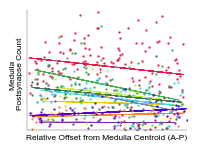

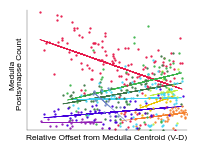

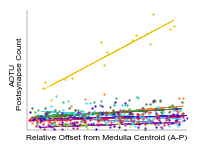

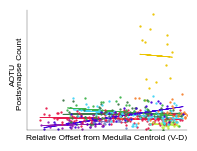

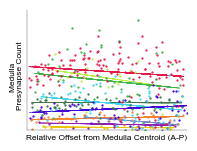

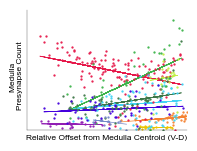

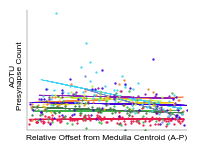

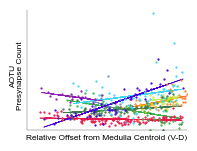

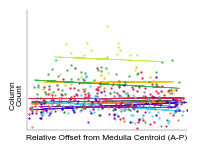

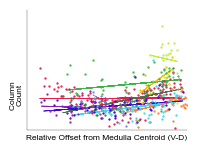

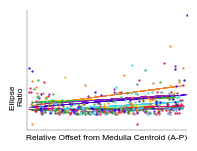

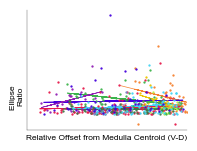

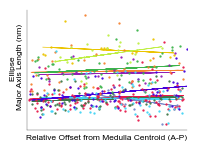

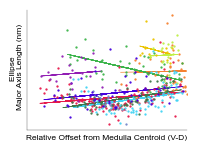

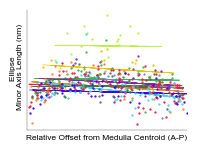

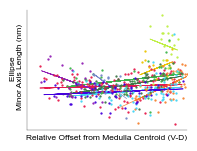

In [8]:
plot_folder = "Test2"

#Fig. EDF10bi-viii
for i in ["Medulla Postsynapse Count", "AOTU Postsynapse Count",
          "Medulla Presynapse Count", "AOTU Presynapse Count",
          "Column Count", "Ellipse Ratio", "Ellipse Major Axis Length (nm)",
          "Ellipse Minor Axis Length (nm)"]:
    for j in ["A-P", "V-D"]:
        comparison.scatter_plots(x=f"Relative Offset from Medulla Centroid ({j})",
                                 y=i, plot_name=f"{i} {j}", plot_folder=plot_folder, format_type=comparison.FormatType.RETINOTOPY)


In [6]:
mapping.get_total_weight(['TuBu08_R'], ['ER4d_R'], 'BU_R')

Fetching synapses: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


{'TuBu08_R': np.float64(0.8)}

In [2]:
maintenance.check_duplicates()

In [ ]:
reduction.region_dict.keys()

In [ ]:
maintenance.check_joined_concurrence(all_mt_l + all_mt_r + tb_l + tb_r + \
                                     er_all + aotu46 + tutu + upstream_neurons + \
                                     ["Mi1_L", "Mi1_R"])

In [ ]:
flywire.get_cave_client(dataset="flat_630").materialize.version

In [ ]:
reduction.region_dict

In [ ]:
df = annotations.client.materialize.query_table("neuron_information_v2", \
                        split_positions=True, materialization_version=annotations.version)
df.info()

In [ ]:
with open('Tags.txt', 'w') as f:
    for i in np.unique(df.tag):
        f.writelines(i)

In [ ]:
glom6 = [f'{x}_R6' for x in ['EPG', 'PEN1', 'PEN2', 'PFNa','PFNd','PFNv','PFNmp', 'PFL1', 'PFL3', 'PEG',]]
#glom6 = [f'{x}_R6' for x in ['EPG', 'PEN1', 'PEN2', 'PFNa','PFNd','PFNv','PFNmp', 'PFL1', 'PFL3',]]
print(glom6)

glom6_map = mapping.ConnectionMap(glom6, glom6, 'PB')
#glom6_map.make_connectivity_plots('Glomerulus 6', save_figure=False, fig_size=(4.0, 4.0))

glom6_map.plot_connectivity(glom6_map.syn_map, \
                        plot_name="Glomerulus 6 Synaptic Connections",
                        plot_folder=plot_folder,
                        #cmap_color=new_colors["Orange"],
                        fig_size=(5.0, 5.0), save_figure=True)



In [ ]:
glom6 = [f'{x}_R6' for x in ['EPG', 'PEN1', 'PEN2', 'PFNa','PFNd','PFNv','PFNmp', 'PFL1', 'PFL3']]#$, 'PEG',]]
print(mapping.ids_from_types(glom6))

In [10]:
mapping.add_broad_type("ER_R", er_r)
mapping.add_broad_type("AOTU046", [f"AOTU046_{x}" for x in "LR"])
all_ring_weights = mapping.get_total_weight(tb_r+["AOTU046"], 
        ["ER_R"], 
        region="BU_R",
        rounded=1)

Fetching synapses: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]


In [11]:
all_ring_weights

{'TuBu01_R': np.float64(0.1),
 'TuBu02_R': np.float64(0.1),
 'TuBu03_R': np.float64(0.2),
 'TuBu04_R': np.float64(0.0),
 'TuBu05_R': np.float64(0.0),
 'TuBu06_R': np.float64(0.1),
 'TuBu07_R': np.float64(0.1),
 'TuBu08_R': np.float64(0.1),
 'TuBu09_R': np.float64(0.0),
 'TuBu10_R': np.float64(0.1),
 'AOTU046': np.float64(0.0)}